In [1]:
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets.base import Bunch

from regain.datasets.poisson import poisson_sampler
from regain.datasets.ising import ising_sampler

In [2]:
# Stessa struttura per tutte e tre le distribuzioni 

# scale-free

# erdo-reniy

#generate the base random graph we randomly add 10% of edges we randomly remove 10% of edges

In [3]:

def generate_multiple_class_dataset(n_dim_obs=10, n_edges=2, probability=0.2, n_classes=5, 
                                    _type='scale-free', random_state=None, plot=False):
    if _type=='scale-free':
        graph = nx.random_graphs.barabasi_albert_graph(n=n_dim_obs, m=n_edges, seed=random_state)
    else:
        graph = nx.random_graphs.erdos_renyi_graph(n=n_dim_obs, p=probability, seed=random_state)

    binaries = [nx.adjacency_matrix(graph).todense()]
    zeros = np.where(binaries[0]==0)
    nonzero= np.where(binaries[0]!=0)
    n_to_add = int(0.1*zeros[0].shape[0]) 
    n_to_remove = int(0.1*nonzero[0].shape[0]) 
    for i in range(n_classes-1):
        K_new = binaries[0].copy()
        to_add = np.random.choice(np.arange(zeros[0].shape[0]), n_to_add, replace=False)
        to_remove = np.random.choice(np.arange(nonzero[0].shape[0]), n_to_add, replace=False)
        for ta in to_add:
            a= np.random.choice([0,1], p=[0.2, 0.8])
            K_new[zeros[0][i], zeros[1][i]] = a
            K_new[zeros[1][i], zeros[0][i]] = a
        for ta in to_remove:
            a=np.random.choice([0,1], p=[0.8, 0.2])
            K_new[nonzero[0][i], nonzero[1][i]] = a
            K_new[nonzero[1][i], nonzero[0][i]] = a
        binaries.append(K_new)
    
    Ks_poisson = [b.copy().astype(np.float32) for b in binaries]  
    Ks_gaussian = [b.copy().astype(np.float32) for b in binaries]  
    A = np.random.rand(n_dim_obs, n_dim_obs)-0.5
    A = (A+A.T)/2
    for b, k in zip(binaries,Ks_gaussian):
        k[np.where(b!=0)] = A[np.where(b!=0)]
        np.fill_diagonal(k, 1)
    Ks_ising = [b.copy().astype(np.float32) for b in binaries]  
    A = np.random.rand(n_dim_obs, n_dim_obs)-0.5
    A = np.sign((A+A.T))
    for b, k in zip(binaries,Ks_ising):
        k[np.where(b!=0)] = A[np.where(b!=0)]
        np.fill_diagonal(k, 1)
   
    return binaries, Ks_poisson, Ks_gaussian, Ks_ising

In [4]:
binaries, poisson, gaussian, ising = generate_multiple_class_dataset(n_edges=2)

In [5]:
def sample(n_dim_obs=10, n_samples=100, gaussian=None, ising=None, poisson=None,time_on_axis='first',):
    res= {}
    if gaussian is not None:
        sigmas = list(map(np.linalg.inv, gaussian))
        # map(normalize_matrix, sigmas)  # in place
        data = np.array(
        [
            np.random.multivariate_normal(
                np.zeros(n_dim_obs), sigma, size=n_samples) for sigma in sigmas
        ])

        X = np.vstack(data)
        y = np.repeat(range(len(sigmas)), n_samples).astype(int)

        if time_on_axis == "last":
            data = data.transpose(1, 2, 0)
        gaussian_res = Bunch(data=data, thetas=np.array(gaussian), X=X, y=y)
        res['gaussian'] = gaussian_res
    if poisson is not None:
        data = np.array([poisson_sampler(t, variances=np.zeros(n_dim_obs),
                               n_samples=n_samples) for t in poisson])
        X = np.vstack(data)
        y = np.repeat(range(len(poisson)), n_samples).astype(int)

        if time_on_axis == "last":
            data = data.transpose(1, 2, 0)
        poisson_res = Bunch(data=data, thetas=np.array(poisson), X=X, y=y)
        res['poisson'] = poisson_res
    if ising is not None:
        data = np.array([ising_sampler(t, np.zeros(n_dim_obs), n=n_samples, responses=[-1, 1])
                        for t in ising])
        X = np.vstack(data)
        y = np.repeat(range(len(poisson)), n_samples).astype(int)

        if time_on_axis == "last":
            data = data.transpose(1, 2, 0)
        ising_res = Bunch(data=data, thetas=np.array(ising), X=X, y=y)
        res['ising'] = ising_res
    return res

In [6]:
 res = sample(n_dim_obs=10, n_samples=100, gaussian=gaussian, ising=ising, poisson=poisson)

/home/vero/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':


In [7]:
def multi_class_kernel(n_classes=5, beta=1):
    kernel = np.ones((n_classes, n_classes))*beta
    np.fill_diagonal(kernel, 1)
    return kernel

In [8]:
kernel = multi_class_kernel(beta=10)

# Fitting

In [9]:
from regain.covariance.kernel_time_graphical_lasso_ import KernelTimeGraphicalLasso
from regain.generalized_temporal_linear_model.poisson import TemporalPoissonModel
from regain.generalized_temporal_linear_model.ising import TemporalIsingModel
from regain.utils import structure_error

In [10]:
tglk = KernelTimeGraphicalLasso(alpha=8, kernel=kernel, psi='l1')
tigmk = TemporalIsingModel(alpha=8, kernel=kernel, psi='l1')
tpgmk = TemporalPoissonModel(alpha=8, kernel=kernel, psi='l1')

from sklearn.model_selection import StratifiedShuffleSplit
import warnings 

warnings.simplefilter('ignore')
sizes = [5, 10, 50, 100]
res_g = {s:[] for s in sizes}
res_i = {s:[] for s in sizes}
res_p = {s:[] for s in sizes}
for s in sizes:
    sss = StratifiedShuffleSplit(n_splits=3, train_size=s)
    for train, _ in sss.split(res['gaussian']['X'],res['gaussian']['y']):
        tglk.fit(res['gaussian']['X'][train, :],res['gaussian']['y'][train])
        res_g[s].append(tglk.precision_)

        tigmk.fit(res['ising']['X'][train, :],res['ising']['y'][train])
        res_i[s].append(tigmk.precision_)
        
        tpgmk.fit(res['poisson']['X'][train, :],res['poisson']['y'][train])
        res_p[s].append(tpgmk.precision_)
    print("done ",s )

(5, 10, 10)
(5, 10, 10)
(5, 10, 10)
done  5
(5, 10, 10)
(5, 10, 10)
(5, 10, 10)
done  10
(5, 10, 10)
(5, 10, 10)
(5, 10, 10)
done  50
(5, 10, 10)
(5, 10, 10)
(5, 10, 10)
done  100


In [12]:
scores = ['mcc', 'precision', 'recall', 'specificity']
means_g = {k:[] for k in scores}
std_g = {k:[] for k in scores}
means_i = {k:[] for k in scores}
std_i = {k:[] for k in scores}
means_p = {k:[] for k in scores}
std_p = {k:[] for k in scores}


for s in sizes:
    err = {k:[] for k in scores}
    for r in res_g[s]:
        err_str = structure_error(res['gaussian']['thetas'], r)
        for i in scores:
            err[i].append(err_str[i])
    for i in scores:
        means_g[i].append(np.mean(err[i]))
        std_g[i].append(np.std(err[i]))
    
    err = {k:[] for k in scores}
    for r in res_i[s]:
        err_str = structure_error(res['ising']['thetas'], r)
        for i in scores:
            err[i].append(err_str[i])
    for i in scores:
        means_i[i].append(np.mean(err[i]))
        std_i[i].append(np.std(err[i]))
    
    
    err = {k:[] for k in scores}
    for r in res_p[s]:
        err_str = structure_error(res['poisson']['thetas'], r)
        for i in scores:
            err[i].append(err_str[i])
    for i in scores:
        means_p[i].append(np.mean(err[i]))
        std_p[i].append(np.std(err[i]))

In [14]:
tglk = KernelTimeGraphicalLasso(alpha=8, kernel=kernel, psi='l2')
tigmk = TemporalIsingModel(alpha=8, kernel=kernel, psi='l2')
tpgmk = TemporalPoissonModel(alpha=8, kernel=kernel, psi='l2')

from sklearn.model_selection import StratifiedShuffleSplit
import warnings 

warnings.simplefilter('ignore')
sizes = [5, 10, 50, 100]
res_g2 = {s:[] for s in sizes}
res_i2 = {s:[] for s in sizes}
res_p2 = {s:[] for s in sizes}
for s in sizes:
    sss = StratifiedShuffleSplit(n_splits=3, train_size=s)
    for train, _ in sss.split(res['gaussian']['X'],res['gaussian']['y']):
        tglk.fit(res['gaussian']['X'][train, :],res['gaussian']['y'][train])
        res_g2[s].append(tglk.precision_)

        tigmk.fit(res['ising']['X'][train, :],res['ising']['y'][train])
        res_i2[s].append(tigmk.precision_)
        
        tpgmk.fit(res['poisson']['X'][train, :],res['poisson']['y'][train])
        res_p2[s].append(tpgmk.precision_)
    print("done ",s )

(5, 10, 10)
(5, 10, 10)
(5, 10, 10)
done  5
(5, 10, 10)
(5, 10, 10)
(5, 10, 10)
done  10
(5, 10, 10)
(5, 10, 10)
(5, 10, 10)
done  50
(5, 10, 10)
(5, 10, 10)
(5, 10, 10)
done  100


In [15]:
scores = ['mcc', 'precision', 'recall', 'specificity']
means_g2 = {k:[] for k in scores}
std_g2 = {k:[] for k in scores}
means_i2 = {k:[] for k in scores}
std_i2 = {k:[] for k in scores}
means_p2 = {k:[] for k in scores}
std_p2 = {k:[] for k in scores}


for s in sizes:
    err = {k:[] for k in scores}
    for r in res_g2[s]:
        err_str = structure_error(res['gaussian']['thetas'], r)
        for i in scores:
            err[i].append(err_str[i])
    for i in scores:
        means_g2[i].append(np.mean(err[i]))
        std_g2[i].append(np.std(err[i]))
    
    err = {k:[] for k in scores}
    for r in res_i2[s]:
        err_str = structure_error(res['ising']['thetas'], r)
        for i in scores:
            err[i].append(err_str[i])
    for i in scores:
        means_i2[i].append(np.mean(err[i]))
        std_i2[i].append(np.std(err[i]))
    
    
    err = {k:[] for k in scores}
    for r in res_p2[s]:
        err_str = structure_error(res['poisson']['thetas'], r)
        for i in scores:
            err[i].append(err_str[i])
    for i in scores:
        means_p2[i].append(np.mean(err[i]))
        std_p2[i].append(np.std(err[i]))

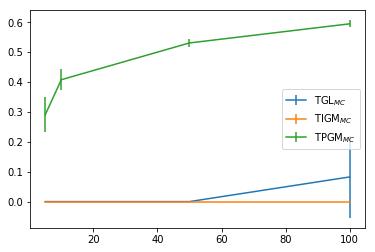

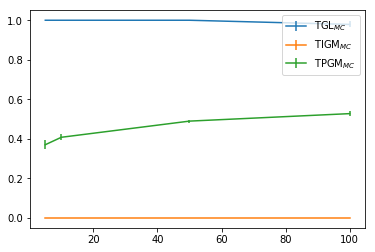

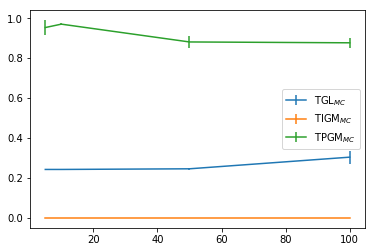

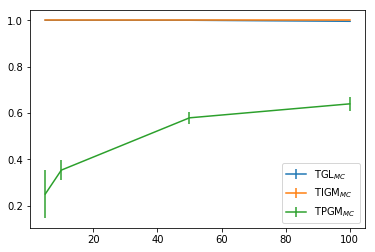

In [13]:
import matplotlib.pyplot as plt 

for s in scores:
    plt.errorbar(sizes, means_g[s], yerr=std_g[s],label=r'TGL$_{MC}$')
    plt.errorbar(sizes, means_i[s], yerr=std_i[s],label=r'TIGM$_{MC}$')
    plt.errorbar(sizes, means_p[s], yerr=std_p[s],label=r'TPGM$_{MC}$')
    plt.legend()
    plt.show()

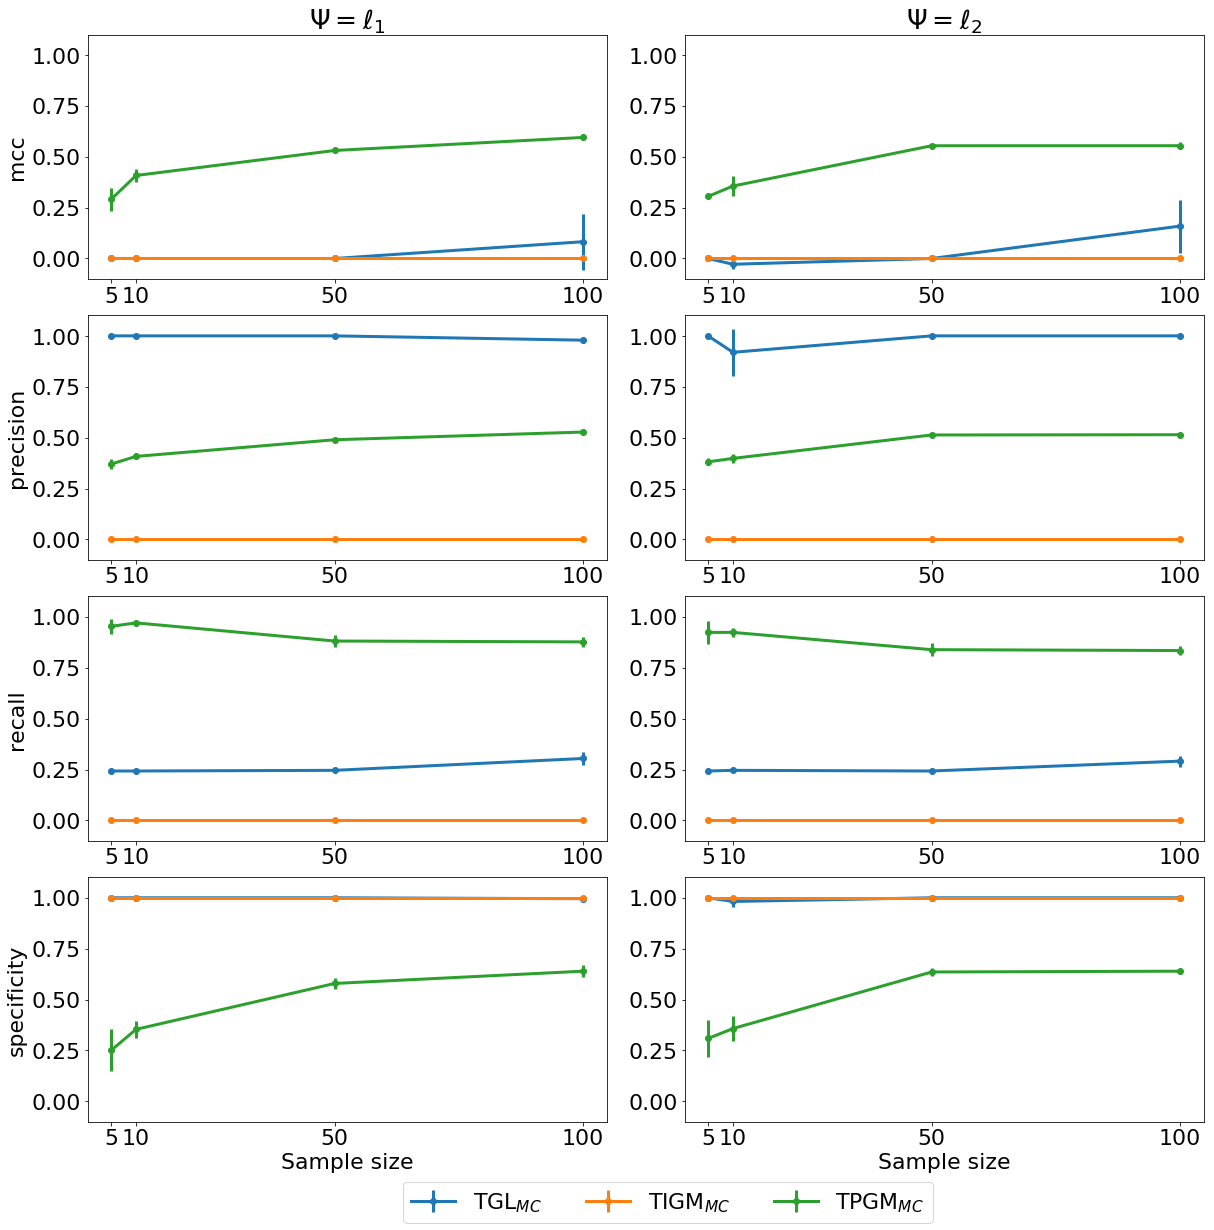

In [17]:
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(20, 20))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(wspace=0.15, hspace=0.15) # set the spacing between axes. 

    
#fig, ax = plt.subplots(4,2, figsize=(15,20), sharex=True, sharey=True)
j = 0
for i, s in enumerate(scores):
    ax = plt.subplot(gs1[j])
    if j==0:
        ax.set_title(r'$\Psi=\ell_1$')
    ax.set_ylabel(s)
    ax.errorbar(sizes, means_g[s], yerr=std_g[s], marker='o', linewidth=3,label=r'TGL$_{MC}$')
    ax.errorbar(sizes, means_i[s], yerr=std_i[s],marker='o',linewidth=3,label=r'TIGM$_{MC}$')
    ax.errorbar(sizes, means_p[s], yerr=std_p[s],marker='o',linewidth=3,label=r'TPGM$_{MC}$')
    ax.set_xticks(sizes)
    if j==6:
        ax.set_xlabel('Sample size')
    plt.ylim(-0.1,1.1)
    ax = plt.subplot(gs1[j+1])
    if j==0:
        ax.set_title(r'$\Psi=\ell_2$')
    ax.errorbar(sizes, means_g2[s], yerr=std_g2[s],marker='o',linewidth=3,label=r'TGL$_{MC}$')
    ax.errorbar(sizes, means_i2[s], yerr=std_i2[s],marker='o',linewidth=3,label=r'TIGM$_{MC}$')
    ax.errorbar(sizes, means_p2[s], yerr=std_p2[s],marker='o',linewidth=3,label=r'TPGM$_{MC}$')
    ax.set_xticks(sizes)
    plt.ylim(-0.1,1.1)
    if j==6:
        ax.set_xlabel('Sample size')
    j+=2

plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.2))
plt.savefig("../../../../Dropbox (DIBRIS)/PhD/PhD thesis/Images/temporal-models/multi-class10nodes-scalefree.pdf", 
           transparent=True, dpi=200, bbox_inches='tight')
plt.show()